In [3]:
import numpy as np
import pandas as pd
import darts
from darts import TimeSeries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, r2_score, rmse

from darts.models import (
    AutoARIMA,
    Prophet,
    RNNModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel,
)

In [4]:
df = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=['Date'])
df.sample(10)
df = pd.concat([df.drop(columns='StateHoliday'), pd.get_dummies(df.StateHoliday, prefix='Holiday')], axis=1)

In [6]:
def get_sample(num):
    sample = df[df.Store == num]
    series = TimeSeries.from_dataframe(sample, 'Date', 'Sales', fill_missing_dates=True)

    train, val = series.split_before(pd.Timestamp("20150101"))
    val, test = val.split_before(pd.Timestamp("20150601"))

    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    test_transformed = transformer.transform(test)

    series_customers = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Customers')
    series_open = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Open')
    series_promo = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Promo')
    series_school = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='SchoolHoliday')
    series_weekday = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='DayOfWeek')
    series_holiday_a = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_a')
    series_holiday_b = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_b')
    series_holiday_c = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_c')

    covariates = series_customers.stack(series_open)
    covariates = covariates.stack(series_promo)
    covariates = covariates.stack(series_school)
    covariates = covariates.stack(series_weekday)
    covariates = covariates.stack(series_holiday_a)
    covariates = covariates.stack(series_holiday_b)
    covariates = covariates.stack(series_holiday_c)

    return train_transformed, val_transformed, test_transformed, covariates

In [7]:
sdf = df[df.Store == 1]
sdf[(sdf.StateHoliday == 'c') & (sdf.Open == 1)]

AttributeError: 'DataFrame' object has no attribute 'StateHoliday'

In [88]:
sdf[(sdf.SchoolHoliday == '1') & (sdf.Open == 1)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [89]:
train_transformed, val_transformed, test_transformed, covariates = get_sample(1)

In [90]:
sdf.groupby('Promo').sum()

,Store,DayOfWeek,Sales,Customers,Open,SchoolHoliday
Promo,,,,,,
0,582,2686,1861815,232615,431,114
1,360,1080,1855039,207908,350,79


## 1. Base Model

In [91]:
def evaluate_model(model, train, test):
    model.fit(train)
    pred = model.predict(len(test))

    plt.figure(figsize=(15, 6))
    test.plot(label="actual")
    pred.plot(label="forecast")

    print("sMAPE: {}".format(smape(pred, test)))
    print("RMSE: {}".format(rmse(test, pred)))
    plt.title(f'{model.__class__.__name__}')
    

sMAPE: 51.16867995410181
RMSE: 0.20606297783008987


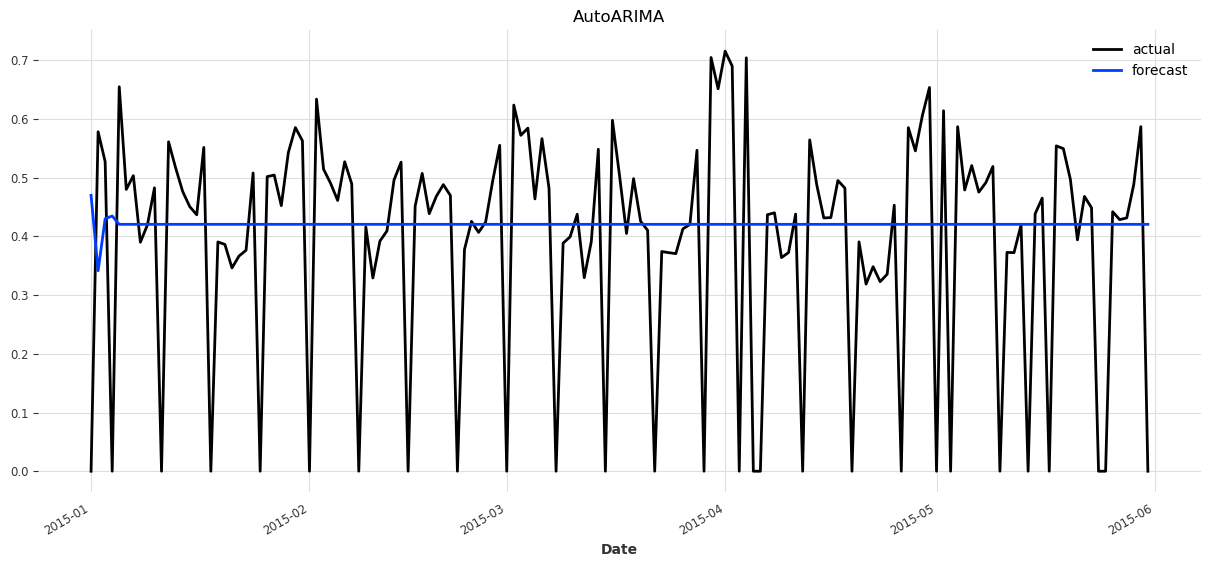

In [92]:
for num in store_num_list:
    train_transformed, val_transformed, test_transformed, covariates = get_sample(num)
    auto_arima = AutoARIMA()
    evaluate_model(auto_arima, train_transformed, val_transformed )

22:27:20 - cmdstanpy - INFO - Chain [1] start processing
22:27:21 - cmdstanpy - INFO - Chain [1] done processing


sMAPE: 52.331891939778984
RMSE: 0.1505589914353113


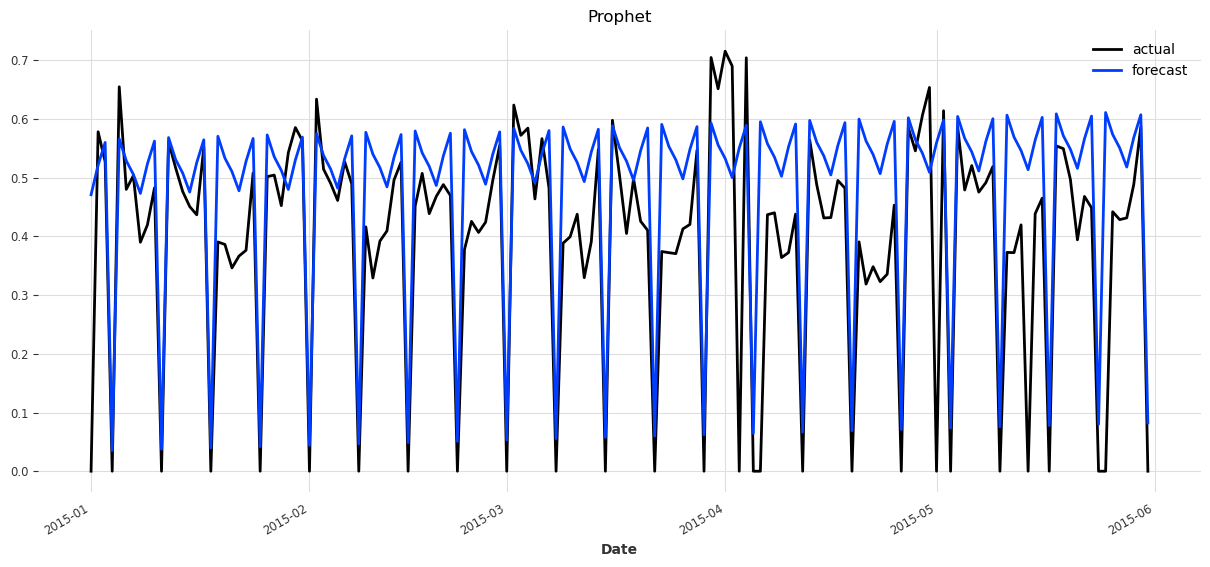

In [93]:
prophet = Prophet()
evaluate_model(prophet, train_transformed, val_transformed )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

sMAPE: 76.34766434581705
RMSE: 0.25974511051951765


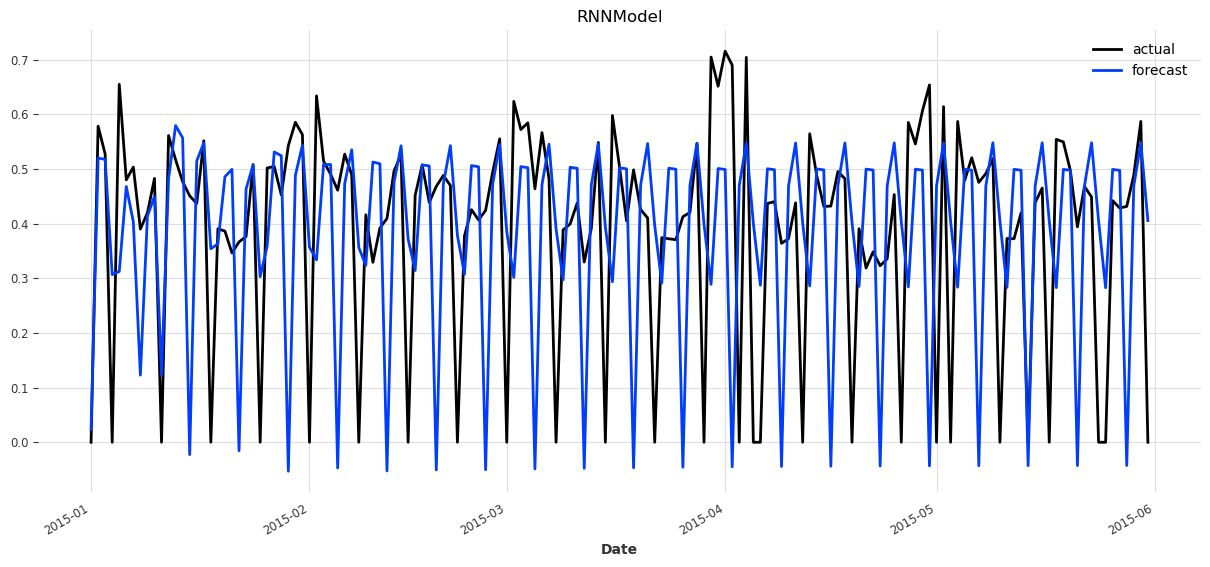

In [94]:
rnn_model = RNNModel(
    input_chunk_length=30, 
    training_length=10, 
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)
evaluate_model(rnn_model, train_transformed, val_transformed )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 260   
---------------------------------------------------
960       Trainable params
0         Non-trainable params
960       Total params
0.008     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

sMAPE: 48.958960723835986
RMSE: 0.12493541655587906


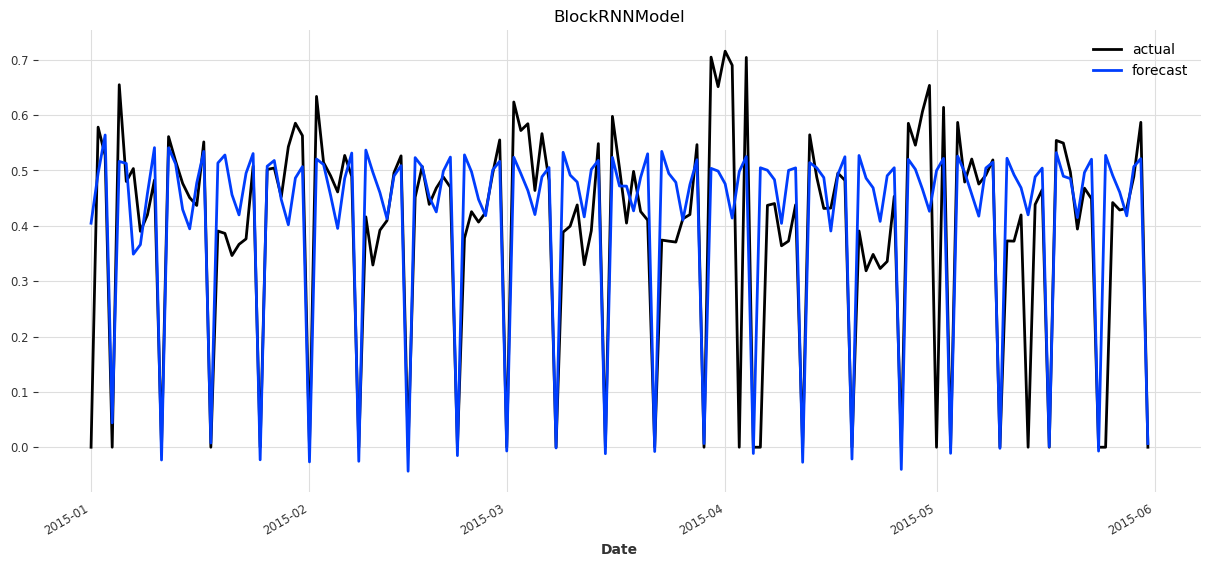

In [95]:
brnn_model = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)
evaluate_model(brnn_model, train_transformed, val_transformed )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
49.811    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

sMAPE: 80.70268809510225
RMSE: 0.3385497254707417


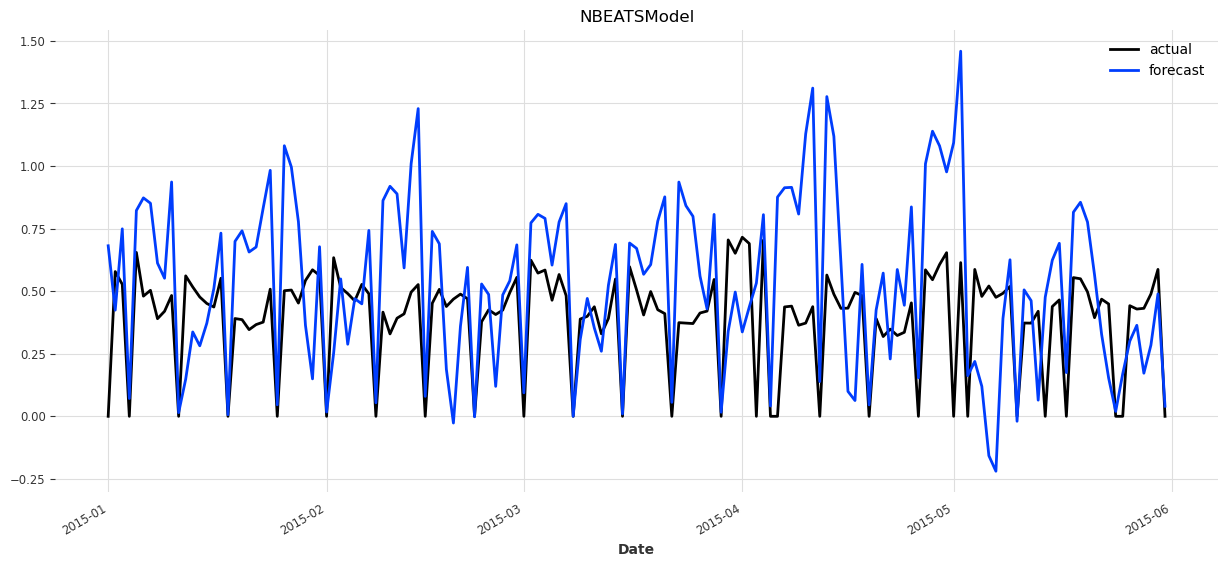

In [96]:
nbeats_model = NBEATSModel(
    input_chunk_length=28,
    output_chunk_length=1,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)
evaluate_model(nbeats_model, train_transformed, val_transformed )

## 2. Covariates Model

In [97]:
train_covariates, val_covariates = covariates.split_before(pd.Timestamp("20150101"))
val_covariates, test_covariates = val_covariates.split_before(pd.Timestamp("20150601"))

### 1. Auto Arima

AutoARIMA
sMAPE: 41.92108581792944
RMSE: 0.03227523803326895


Text(0.5, 1.0, 'AutoARIMA')

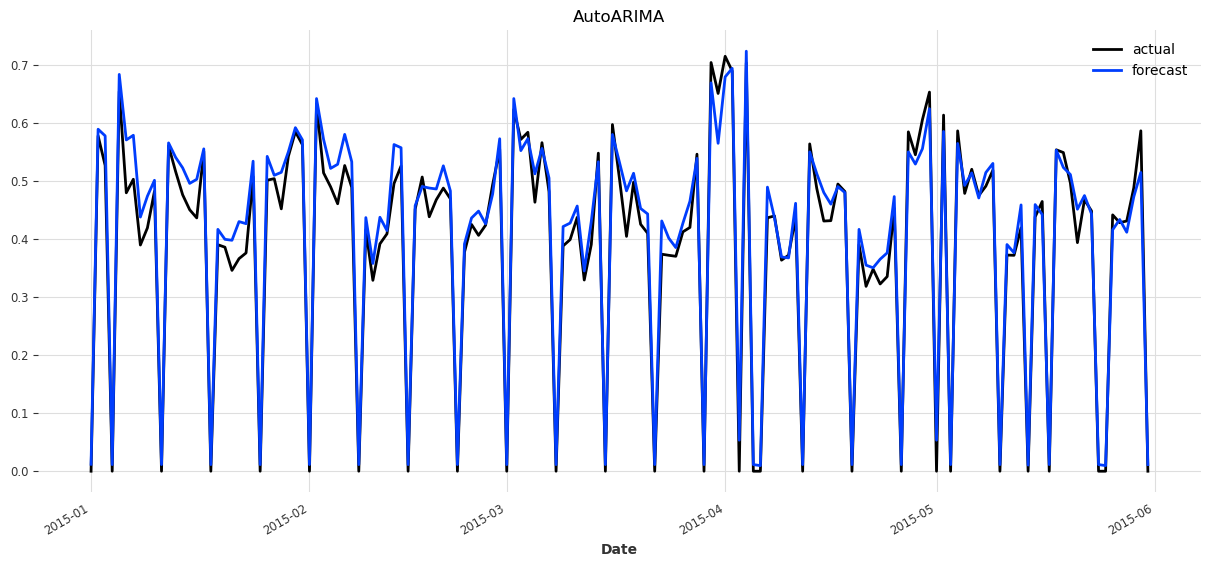

In [98]:
auto_arima = AutoARIMA()
auto_arima.fit(train_transformed, future_covariates=train_covariates)
pred_demand_covs = auto_arima.predict(len(val_transformed), future_covariates=val_covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('AutoARIMA')
print("sMAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('AutoARIMA')

### Prophet

22:50:45 - cmdstanpy - INFO - Chain [1] start processing
22:50:45 - cmdstanpy - INFO - Chain [1] done processing


PROPHET
sMAPE: 41.355503369758786
RMSE: 0.028977541022327247


Text(0.5, 1.0, 'PROPHET')

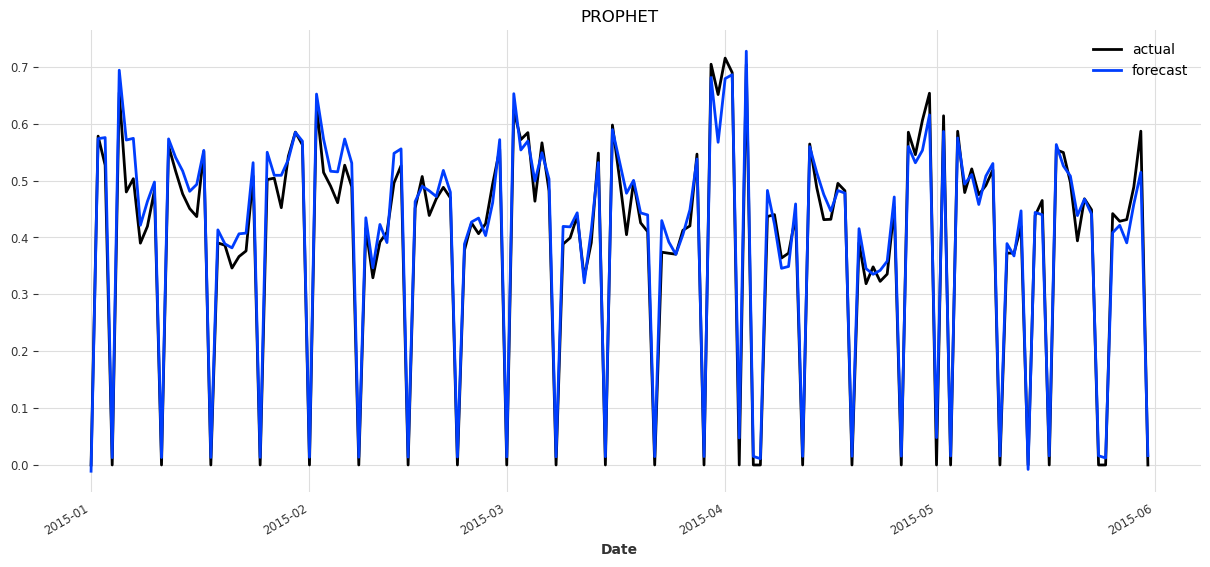

In [99]:
prophet = Prophet()
prophet.fit(train_transformed, future_covariates=train_covariates)
pred_demand_covs = prophet.predict(len(val_transformed), future_covariates=val_covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")

print('PROPHET')
print("sMAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('PROPHET')

### 3. RNN Model

In [100]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

RNNModel
MAPE: 40.99128468626777
RMSE: 0.026470319943011043


Text(0.5, 1.0, 'RNNModel')

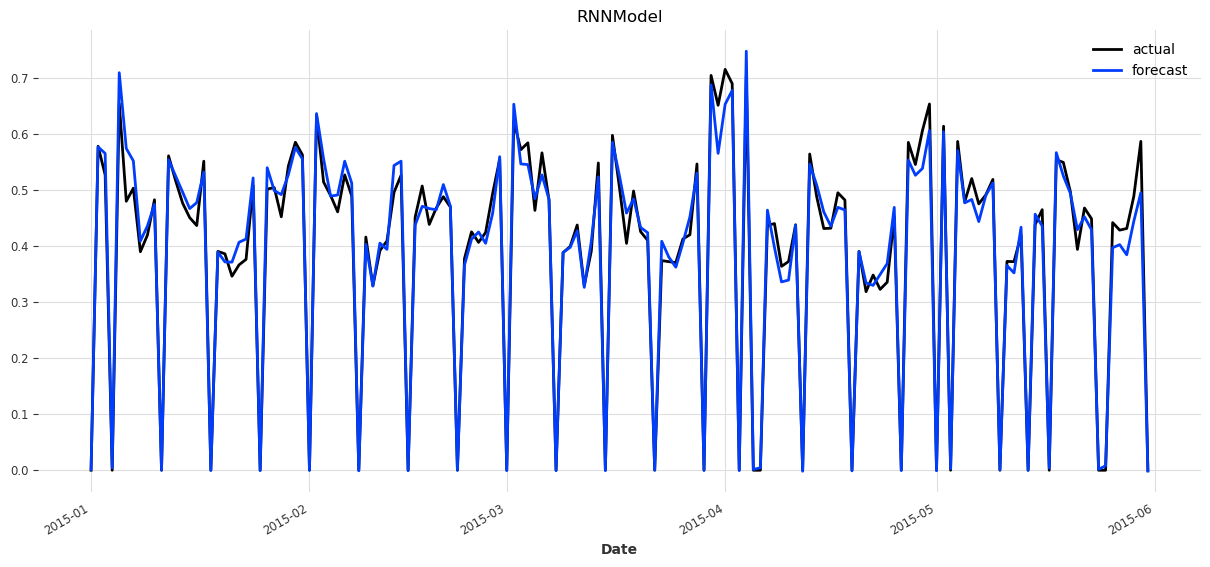

In [101]:
rnn_model = RNNModel(
    model="LSTM",
    input_chunk_length=30, 
    training_length=40, 
    n_rnn_layers=2,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

rnn_model.fit(
    train_transformed,
    future_covariates=train_covariates,
    verbose=False,
)

pred_demand_covs = rnn_model.predict(len(val_transformed), future_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('RNNModel')
print("MAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('RNNModel')

### 4. BlockRNN 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

BlockRNNModel
MAPE: 49.12058131489169
RMSE: 0.12634083644008412


Text(0.5, 1.0, 'BlockRNNModel')

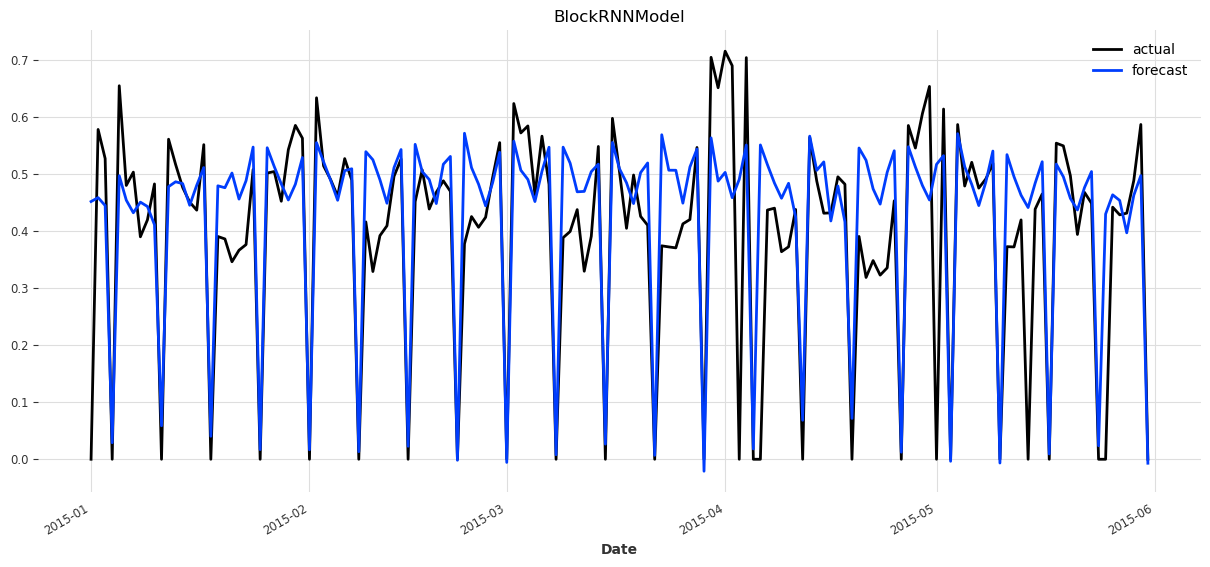

In [102]:
brnn_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=30, 
    output_chunk_length=10, 
    n_rnn_layers=2,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

brnn_model.fit(
    train_transformed,
    past_covariates=train_covariates,
    verbose=False
)

pred_demand_covs = brnn_model.predict(len(val_transformed), past_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('BlockRNNModel')
print("MAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('BlockRNNModel')

### 5. NBeats

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

BlockRNNModel
MAPE: 61.31605805576316
RMSE: 0.22019677435947546


Text(0.5, 1.0, 'NBeats')

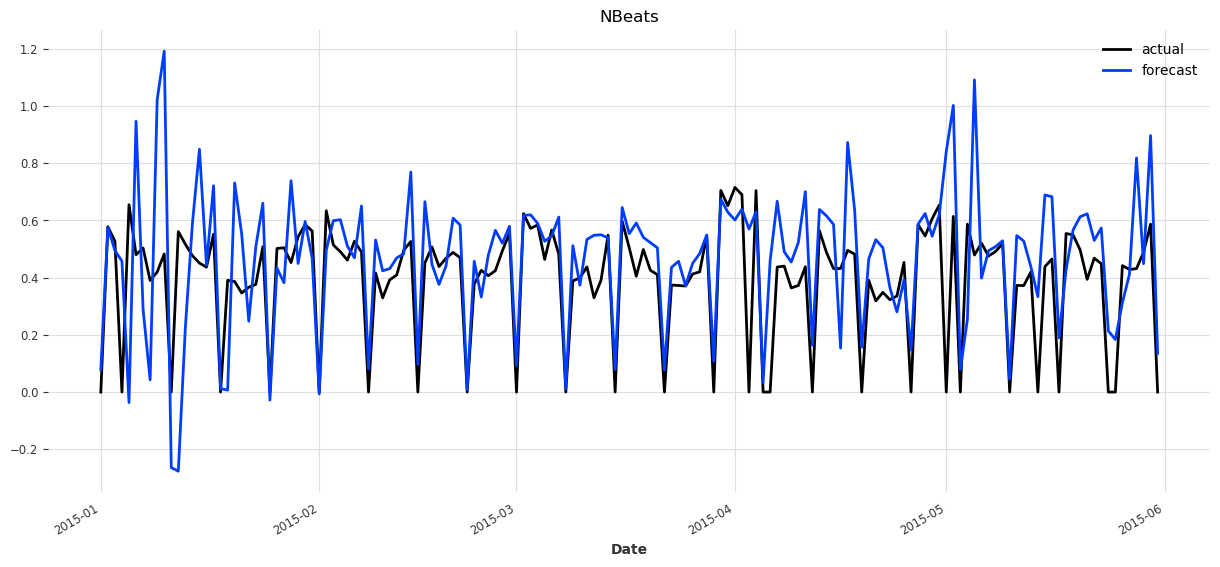

In [103]:
nbeats_model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

nbeats_model.fit(
    train_transformed,
    past_covariates=train_covariates,
    verbose=False
)

pred_demand_covs = nbeats_model.predict(len(val_transformed), past_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('BlockRNNModel')
print("MAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('NBeats')